***Partie programmation***
--------------------

________

In [1]:
#on importe toutes les librairies et modules qui nous seront nécessaires

import json
from textblob import TextBlob
import random
import string
import pandas as pd
import re
from matplotlib import pyplot as plt 

import nltk 
from nltk.stem import *
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

import gensim
from gensim.models.phrases import Phrases, Phraser  #utile pour nos bigrams, trigrams etc.
from gensim.models import CoherenceModel
import pickle   #utile pour stocker des datasets importants

#pour la visualisation des topics
import pyLDAvis
import pyLDAvis.gensim

In [2]:
#on ouvre le fichier json en mode lecture 
#on récupère chaque dictionnaire dans une liste
with open("jeuTweet/zone_atterissage.json","r",encoding='utf-8') as file:
    data = json.load(file)

#on crée un dataframe contenant nos tweets, celui ci nous servira pour la modélisation de sujets
data = [{"Text":i['TweetText']} for i in data]
data = pd.DataFrame(data)


In [3]:
#-------- implémentation de la LDA --------#

languages = stopwords.fileids()
stopword = set()
for lang in languages:
    stopword.update(stopwords.words(lang))

#nettoyage de texte :
#ici on va supprimer tous les éléments non pertinents du tweet, tel que les mentions et les URLs
#nous ne supprimerons pas les # car ils servent souvent de méta-tag pour indiquer le sujet principal du tweet

#on retire les urls
def url_remover(texte):
    return re.sub(r'https:\S*',"",texte)

#on retire les mentions 
def mention_remover(texte):
    return re.sub(r'@\S*',"",texte)

#on garde les hashtags mais sans le symbole #, ceux ci peuvent nous être utile pour trouver nos sujets
def hashtag_to_word(texte):
    return re.sub(r'#(\S+)',r'\1',texte)

#on applique chacune de ces fonctions sur nos tweets
data['Text'] = data['Text'].apply(url_remover)
data['Text'] = data['Text'].apply(mention_remover)
data['Text'] = data['Text'].apply(hashtag_to_word)


#maintenant on va tokeniser nos documents
#on créera une fonction qui retournera une liste de listes, où chaque liste contient des tokens d'un document

corpus = []   #on crée la liste qui contiendra les listes de tokens

lem = WordNetLemmatizer()   #on utilisera ceci ultérieurement pour lemmatiser

def pre_process(df):
    for tweet in df["Text"]:
        mots = [x for x in word_tokenize(tweet) if (x.lower() not in stopword)]
        mots = [lem.lemmatize(x) for x in mots if len(x)>2]   #la condition len>2 est utilisée pour fitlrer les mots courts qui n'ont
                                                            #pas beaucoup d'impact tel que "an", "is" ou même "RT"
        corpus.append(mots)
    return corpus

corpus = pre_process(data)

#ici on va concevoir des bigrams, trigrams et quadrigrams
#cela va nous permettre d'inclure comme topic des groupes de mots, tel que 'artificial intelligence'
phrases = Phrases(corpus, min_count = 20, threshold = 10)
bigram = Phraser(phrases)
corpus = [bigram[truc] for truc in corpus]

phrases = Phrases(corpus, min_count = 20, threshold = 10)
trigram = Phraser(phrases)
corpus = [trigram[truc] for truc in corpus]

phrases = Phrases(corpus, min_count = 20, threshold = 10)
quadrigram = Phraser(phrases)
corpus = [quadrigram[truc] for truc in corpus]


#maintenant on va transformer tout ceci en dictionnaire gensim

dictionnaire = gensim.corpora.Dictionary(corpus)   #objet qui fait le lien entre un mot unique et son id 

#transformation en bag-of-words
#ici on va prendre chaque liste de tokens dans notre corpus et la représenter par un vecteur BoW qui indique la fréquence de chaque mot dans le document  
#il est à préciser qu'on ignore l'ordre des mots et la structure grammaticale 
bagofwords = [dictionnaire.doc2bow(document) for document in corpus]  

#le module pickle permet de sérialiser et désérialiser (enregistrer et charger) des objets dans un fichier 
pickle.dump(bagofwords, open('corpus.pkl','wb'))   #on enregistre l'objet dans le fichier corpus.pkl en mode écriture binaire 

dictionnaire.save('dictionary.gensim')


#création du modèle 
# Note : on utilise la méthode LDA Multicore (qui supporte le multi-processing) pour ces raisons : 
#     - traitement des données nettement plus rapide : si l'algo est divisé pour s'executer sur plusieurs coeurs en parrallèle, il s'exécutera nettement plus vite
#     - traitement de grands volumes de données : le multi-processing permet de traiter les grosses quantités de données (comme dans le jeu de tweet) beaucoup plus efficacement en distribuant la charge sur plusieurs coeurs   
#     -utilisation optimale des ressources : étant donné que la plupart des ordinateurs sont dotés de processeurs multicoeurs, ne pas les utiliser serait du gachis. 

modele = gensim.models.LdaMulticore(bagofwords,
                                   num_topics=20,
                                   id2word=dictionnaire,
                                   passes=9,
                                   workers=2)

#on sauvegarde le modele 
modele.save('modele.gensim')


#maintenant on va reload notre bagofword et notre modele afin de les utiliser ultérieurement
with open('corpus.pkl','rb') as file:
    bagofwords = pickle.load(file)

modele = gensim.models.LdaMulticore.load('modele.gensim')

In [4]:
#-------- Opérations de traitement --------#

#ici, on crée une classe qui nous permettera de créer une dataframe 
#cette dataframe résultera des opérations de traitement, et chaque instance correspond à un tweet, soit une ligne de la dataframe

class OP_Traitement:
    def __init__(self, texte, auteur, lda_modele, dictionary):
        self.texte = texte
        self.auteur = auteur
        self.hashtags = self.hashtags_tweet()
        self.mentions = self.mentions_tweet()
        self.sentiment = self.sentiment_tweet()
        self.modele = lda_modele
        self.dico = dictionary
        self.sujet = self.topic()

    #fonction nous permettant de créer un dictionnaire portant pour clés-valeurs les résultantes des opérations de traitement
    def to_dico(self):
        dico = {"Texte": self.texte,"Auteur":self.auteur,"Hashtags":self.hashtags,"Mentions":self.mentions,"Sentiment":self.sentiment,"Sujet":self.sujet}
        return dico
    
    #fonction qui extrait tous les hashtags d'un tweet
    def hashtags_tweet(self):
        return re.findall(r'#\w+(?!#)',self.texte)

    #fonction qui extrait toutes les mentions d'un tweet
    def mentions_tweet(self):
        return re.findall(r'@\w+(?!@)',self.texte)
    
    #fonction qui extrait le sentiment d'un tweet
    def sentiment_tweet(self):
        sentiment = "" 
        #à l'aide du module textblob on vient extraire la polarité du texte
        #puis on détérmine s'il est positif ou négatif
        if TextBlob(self.texte).sentiment.polarity > 0 :
            sentiment = "positif"
        elif TextBlob(self.texte).sentiment.polarity == 0 :
            sentiment = "neutre"
        else:
            sentiment = "negatif"
        return sentiment
    
    #fonction qui extrait les topics du tweet
    #ici, on se sert de notre modele et notre dictionnaire afin d'extraire les topics de chaque tweet
    def topic(self):
        # on procède à un nettoyage du texte du tweet
        tweet = re.sub(r'https?:\S+', '', self.texte)
        tweet = re.sub(r'@\S+', '', tweet)
        tweet = re.sub(r'#(\S+)', r'\1', tweet)

        # tokenisation et lemmatisation, on procède de la même manière que précedemment
        mots = [x for x in word_tokenize(tweet) if (x.lower() not in stopword)]
        mots = [lem.lemmatize(x) for x in mots if len(x) > 2]

        # conversion en bag of words
        bow_tweet = self.dico.doc2bow(mots)

        # extraction des sujets à l'aide du modèle LDA
        sujets = self.modele.get_document_topics(bow_tweet)

        # ici on trouve le sujet dominant
        sujet_dominant, proba = max(sujets, key=lambda item: item[1])

        # on obtient les mots clés pour le sujet dominant, ici on en prend uniquement trois
        mots_cles_sujet = [mot for mot, _ in self.modele.show_topic(sujet_dominant, topn=3)]

        # on filtre les redondances de nos topics tout en conservant leur forme originale
        # cela va nous permettre de ne pas avoir ['Artificial_Intelligence','ArtificialIntelligence','artificial_intelligence] comme les trois sujets du topic
        # entre autre, cela nous permet de diversifier nos topics
        mots_cles_uniques = []
        formes_simplifiees = []
        for mot in mots_cles_sujet:
            mot_simplifie = mot.lower().replace('_', '')
            if mot_simplifie not in formes_simplifiees:
                formes_simplifiees.append(mot_simplifie)
                mots_cles_uniques.append(mot)

        return mots_cles_uniques

In [5]:
#on ouvre le fichier json en mode lecture 
#on récupère chaque dictionnaire dans une liste
with open("jeuTweet/zone_atterissage.json","r",encoding='utf-8') as file:
    data = json.load(file)
    
donnees = []
#on crée toutes les instances que l'on ajoute à une liste afin d'en créer un dataframe
for i in data:
    truc = OP_Traitement(i["TweetText"],i["Auteur"],modele,dictionnaire)
    tweet = truc.to_dico()
    donnees.append(tweet)
dataframe = pd.DataFrame(donnees)
dataframe.to_csv("jeuTweet/dataframe.csv")

In [6]:
#-------- Opérations d'analyse --------#

#ici, on mettera toutes les opérations qui nous serviront d'insight (d'analyse) sur l'ensemble de nos tweets

#fonction qui retourne le top k hashtags, mentions en topics
#ici on utilise la fonction .explode afin d'avoir les éléments d'une même liste sous plusieurs ligne d'un dataframe, comportant le même index
#cela nous facilite le filtrage
def top_k(df,objet,k):
    df = df.explode(objet)
    top = df[objet].value_counts()
    return top.head(k)


#fonction qui retourne le nombre de publications par utilisateur, hashtag, mention ou topic
#ces dernier représentent l'objet, et la variable specific représente spécifiquement celui que l'on cherche 
def nbre_de_publications_par(df,objet,specific):
    df = df.explode(objet)
    specific_df = df[df[objet] == specific]
    return specific_df[objet].value_counts()

#fonction qui retourne l’ensemble de tweets d’un utilisateur spécifique
def edt_user(df,objet,specific):
    filt = (df[objet] == specific)
    return df.loc[filt,'Texte']

#fonction qui retourne l’ensemble de tweets contenant un hashtag ou une mention spécifique
def edt_hashtag_mention(df,objet,specific):
    df = df.explode(objet)
    filt = (df[objet] == specific)
    return df.loc[filt,'Texte']

#fonction qui retourne les utilisateurs mentionnant un hashtag ou une mention spécifique
def mentionned_by(df,objet,specific):
    df = df.explode(objet)
    filt = (df[objet] == specific)
    return df.loc[filt,'Auteur']  

#fonction qui retourne les utilisateurs, hashtags ou mentions mentionnés par un utilisateur spécifique  
def mentioning(df,objet,specific):
    df = df.explode(objet)
    filt = (df['Auteur'] == specific)
    return df.loc[filt,objet]

In [7]:
#ici on crée un graphique qui nous permet de visualiser les statistiques des top k 
#cette fonction prend en paramètres la serie résultante de la fonction top_k ainsi que l'objet que l'on veut visualiser
#elle créera ainsi un graph en fonction de l'occurence des plus utilisés

def graph(tab,objet):
    x, y = tab.keys(), tab.values
    plt.bar(x,y, label=f'Top k {objet}')

    plt.xlabel(f'{objet}')
    plt.ylabel('Count')
    plt.title('Top k')

    plt.legend()
    plt.grid(color='r', linestyle='--', linewidth=0.25)

    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout() 

    plt.show()

'         '

'         '

'         '

***Partie visualisation***
--------------------

________

In [8]:
df = pd.read_csv('jeuTweet/dataframe.csv')
df.head(15)

,Unnamed: 0,Texte,Auteur,Hashtags,Mentions,Sentiment,Sujet
0,0,"@____bruvteresa_ According to research, NASA c...",I2MCQpYdVwP,[],['@____bruvteresa_'],positif,"['Artificial_Intelligence', 'company']"
1,1,RT @HDataSystems: Artificial Intelligence and ...,F4tLFas,"['#hdatasystems', '#Artificia']",['@HDataSystems'],negatif,"['Artificial_Intelligence', 'Tech']"
2,2,RT @adgpi: Army Technology Board conducted the...,fij5M,[],['@adgpi'],negatif,"['artificial_intelligence', 'MachineLearning']"
3,3,"RT @pacorjo: According to a recent survey, the...",2W3lnj4,[],['@pacorjo'],positif,"['A.I', 'artificial_intelligence']"
4,4,RT @HarbRimah: Making AI Sing https://t.co/FJo...,9r6ize,"['#MachineLearning', '#DataScience', '#Python'...",['@HarbRimah'],neutre,"['artificial_intelligence', 'MachineLearning']"
5,5,RT @weblineglobal: The applications of #artifi...,tWsgo9n3pTZ,['#artificialintelligence'],['@weblineglobal'],neutre,"['amp', 'Artificial_Intelligence']"
6,6,RT @sokoworlddotcom: We help our Customers use...,IuPuMUWGI,[],['@sokoworlddotcom'],neutre,"['artificial_intelligence', 'Watch']"
7,7,RT @SuriyaSubraman: US Falling Behind China In...,AyEwFrIH8Sgo,[],['@SuriyaSubraman'],negatif,"['Artificial_Intelligence', 'company']"
8,8,RT @DD_FaFa_: Prediction Machines: The Simple ...,HLiEOYg-Vx61I,"['#AI', '#ArtificialIntelligence']",['@DD_FaFa_'],negatif,"['Artificial_Intelligence', 'China']"
9,9,RT @williamhersh: Latest post to the Informati...,TskN_,[],['@williamhersh'],positif,"['Artificial_Intelligence', 'Tech']"


In [9]:
topk = top_k(dataframe,'Hashtags',10)
topk

Hashtags
#AI                        214
#ArtificialIntelligence    207
#MachineLearning            86
#ai                         52
#DataScience                50
#artificialintelligence     44
#BigData                    25
#learning                   24
#ML                         24
#DeepLearning               21
Name: count, dtype: int64

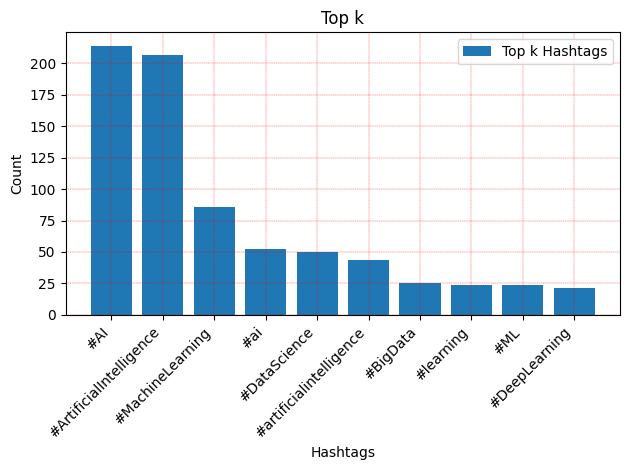

In [10]:
graph(topk,'Hashtags')

In [11]:
nbre_de_publications_par(dataframe,'Auteur','I2MCQpYdVwP')

Auteur
I2MCQpYdVwP    7
Name: count, dtype: int64

In [12]:
edt_user(dataframe,'Auteur','I2MCQpYdVwP')

0       @____bruvteresa_ According to research, NASA c...
194     RT @RIHospital: Can you spot anaemia from a ph...
590     RT @DataAugmented: Googling For Artificial Int...
597     RT @zeditip: IMPACT OF #AI ARTIFICIAL INTELLIG...
1499    RT @sankrant: China focused on excellence in a...
1607    RT @Omkar_Raii: .@CBSEIndia29 in collaboration...
1670    RT @HomeSpaceNFT: [1/2] The Homespace Team has...
Name: Texte, dtype: object

In [13]:
edt_hashtag_mention(dataframe,'Hashtags','#MachineLearning')

4       RT @HarbRimah: Making AI Sing https://t.co/FJo...
52      RT @Udemy_Coupons1: Artificial Intelligence (A...
53      RT @Udemy_Coupons1: Artificial Intelligence (A...
122     RT @digitalkecom: The branches of Artificial I...
155     RT @Paula_Piccard: Decoding crop genetics with...
                              ...                        
1637    RT @bimedotcom: What is the Difference Between...
1638    RT @bimedotcom: What is the Difference Between...
1639    RT @bimedotcom: What is the Difference Between...
1676    RT @Paula_Piccard: Artificial Intelligence len...
1678    RT @HPI_NYC: .@HPI_MS is currently looking for...
Name: Texte, Length: 86, dtype: object

In [14]:
mentionned_by(dataframe,'Mentions','@byLilyV')

13              09vDDjV
14             DKmAKSb^
56                kKgXJ
113         ylbH1EyH2DD
150        AqWBDWLczMJ^
197         Sc7b5c^jk7O
413            DTy~E0^g
418     keJCnparRILGB0A
737        zwWOY5^a~Hwa
813         btYHJXrfA~S
883     uFNRnL7VchHffYZ
1571             an.hQp
1651         C-~TiMO8wJ
Name: Auteur, dtype: object

In [15]:
mentioning(dataframe,'Mentions','I2MCQpYdVwP')

0       @____bruvteresa_
194          @RIHospital
590       @DataAugmented
597             @zeditip
1499           @sankrant
1607         @Omkar_Raii
1607        @CBSEIndia29
1607              @Intel
1670       @HomeSpaceNFT
Name: Mentions, dtype: object

In [16]:
# Loading the dictionary and corpus files we saved earlier
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
# Loading the num_of_topics = 2 model we saved earlier
lda = gensim.models.ldamodel.LdaModel.load('modele.gensim')
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, bagofwords, dictionnaire, sort_topics=False)
pyLDAvis.display(vis)

''

''

''

***Réferences***
--------------------

towardsdatascience.com --> pour la modélisation de topics avec la LDA + visualisation de LDA

medium --> également pour la LDA 

Python tutorial for digital Humanities (youtube) --> pour la LDA 

Github repositories dont le code était en java, mais qui traitaient également de LDA 

ChatGpt m'a également pas mal aidée à dechiffrer la LDA

CodeAvecJonathan (youtube) --> pour la programmation orientée objet

CodeCademy --> pour pratiquer la programmation objet 

Documentation python --> pour apprendre à utiliser les expressions régulières

Corey Schafer - Pandas tutorials (playlist youtube) --> pour apprendre à utiliser pandas 

Documentation python --> pour utiliser pandas également

Corey Scafer (youtube) --> pour apprendre à utiliser matplotlib